In [1]:
# In this notebook, we try to add nonlinear operation locally without
# Unfolding which is very time consuming for "Retina Blood Vessel" dataset
#

In [2]:
# imports
#
import sys
import os
import glob
import time
import numpy as np
import scipy as sp
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm
import matplotlib.pyplot as plt
import plotly
import plotly.subplots
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

import torch, torchvision

from IPython.core.debugger import set_trace

/home/khalkhaliv/Projects/mytorch/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning:

Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory



In [3]:
# Globals
#
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6
br = set_trace

In [5]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath)
train_masks = 1 * (read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath)
test_masks = 1 *(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)
print(train_images.min(), train_images.max(), train_images.mean())
print(train_masks.min(), train_masks.max(), train_masks.mean())

(80, 512, 512, 3) (80, 512, 512) (20, 512, 512, 3) (20, 512, 512)
-1.5989004704853944 4.097728417232479 1.5034270125132329e-18
0 1 0.12315158843994141


In [4]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.float64(img)
            # img = (img - img.min()) / (img.max() + EPSILON)
            # img = 2*img - 1
            # img = np.float64(img)/img.max()
            img = (img - img.mean()) / img.std()
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

class Nonlinear1(torch.nn.Module):
    """
    Image / LocalAverage per channel
    """
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        """
        x: image
        y: local average
        """
        return x / (y + EPSILON)

class Nonlinear2(torch.nn.Module):
    """
    Local variance per channel
    """
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        """
        x: local average of image
        y: local average of square of image
        """
        # std = torch.sqrt(y - x**2 + EPSILON)
        # std = torch.sqrt((y - x**2))
        var = y - x**2
        return var

class Nonlinear3(torch.nn.Module):
    """
    Semi-Sauvola
    """
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        """
        x: local average of image
        y: local variance of image
        """
        sl = x * y
        return sl

class Nonlinear4(torch.nn.Module):
    """
    Combination of several functions until the degree 3
    """
    def __init__(self):
        super().__init__()
        self.params = torch.nn.Parameter(torch.randn(4),
                                         requires_grad=True)
    def forward(self, x, xm, x2m, x3m):
        """
        x: image
        xm: local average of image
        x2m: local average of square of image
        x3m: local average of cubic of image
        """
        # multipy
        y = (self.params[0]*x + self.params[1]*xm + 
             self.params[2]*x2m + self.params[3]*x3m)
        return y

# Locally Nonlinear Block
class LocallyNonlinear(torch.nn.Module):
    def __init__(self, neighbor_radius=[3], degree=1):
        super().__init__()
        neighbor = [2*nr+1 for nr in neighbor_radius]
        self.neighbor = neighbor
        ln = len(neighbor)
        self.degree = degree
        self.convs = torch.nn.ModuleList()
        for n in neighbor:
            conv = torch.nn.Conv2d(in_channels=3, out_channels=3,
                                   kernel_size=n, stride=1,
                                   padding='same', bias=False)
            conv.weight.requires_grad_(False)
            conv.weight = torch.nn.Parameter(
                torch.zeros_like(conv.weight), requires_grad=False)
            for c in range(3):
                conv.weight[c, c, :, :] = 1.0 / n**2
            self.convs.append(conv)
        self.aggregate = torch.nn.Conv2d(
            in_channels=int(3*(1+degree*ln + 
                               3*(1+degree*ln)*(degree*ln)/2)),
            out_channels=2, kernel_size=1, stride=1, 
            padding='same', bias=True)
        # self.aggregate.weight.requires_grad_(False)
        # self.aggregate.weight = torch.nn.Parameter(
        #     torch.ones_like(self.aggregate.weight))
        # self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        # operator, neighbor, degree, batch, channel, height, width
        
        comb = [x]
        for d in range(1, self.degree+1):
            comb += [conv(x**d) for conv in self.convs]
        lcomb = len(comb)
        for c1 in range(lcomb):
            for c2 in range(c1+1, lcomb):
                # print(c1, c2)
                comb.append(comb[c1] - comb[c2])
                comb.append(comb[c1] * comb[c2])
                comb.append(comb[c1] / (comb[c2] + EPSILON))
        # nl2 = [self.nl2(avg, sqavg) 
        #        for avg, sqavg in zip(convs, convs_sq)]  # var = E[X^2] - mu^2
        # aggregation
        aggr = torch.concatenate(comb, axis=1)
        y = self.aggregate(aggr)
        # y = self.sigmoid(y)
        return y


class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
class Train:
    """
    Initialize, train, evaluate, decode
    """
    def __init__(self, model, data, label, nepoch=4, bsize=8):
        """
        data: [batch, num_channel, rows, cols]
        label: [batch, num_channel, rows, cols]
        """
        self.model = model
        self.data = data
        self.label = label
        self.nepoch = nepoch
        self.device = (torch.device("cuda:0")
                       if torch.cuda.is_available()
                       else torch.device('cpu'))
        print('Device: ', self.device)
        weight = torch.Tensor([label.sum()/label.numel(),
                               1-label.sum()/label.numel()])
        print('Weight: ', weight)
        self.crit = torch.nn.CrossEntropyLoss(weight=weight.to(self.device))
        # self.crit = torch.nn.MSELoss()
        # self.crit = DiceLoss()
        # self.crit = DiceBCELoss()
        self.bsize = bsize
    def run(self, lr=1e-4):
        model = self.model
        model = model.to(self.device)
        crit = self.crit
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        # sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optim, factor=0.5, patience=4, threshold=0.001)
        t1 = time.time()
        for epoch in range(self.nepoch):
            # t1 = time.time()
            model, optim = self._train(model, crit, optim)
            
            loss = self._valid(model, crit)
            # sch.step(loss)
            # if lr != optim.param_groups[0]['lr']:
            #     lr = optim.param_groups[0]['lr']
            #     print(f'Learning rate changed to {lr:.04f}.')
            if (epoch % 10 == 0) | (epoch == (self.nepoch-1)):
                print(f'Ep: {epoch}, Secs: {time.time() - t1:.0f}, ' +
                      f'loss: {loss:.04f}')
                t1 = time.time()
        return model
            
    def _train(self, model, crit, optim):
        model.train()
        for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                        1*(self.data.shape[0] % self.bsize != 0)):
            slc = slice((bc-1)*self.bsize, bc*self.bsize)
            batch, lb = self.data[slc, :, :, :], self.label[slc].long()
            batch, lb = batch.to(self.device), lb.to(self.device)
            optim.zero_grad()
            out = model(batch)
            out = out.softmax(dim=1)
            # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
            #             lb.flatten())
            loss = crit(out, lb)
            loss.backward()
            optim.step()
        return model, optim
    
    def _valid(self, model, crit):
        model = model.to(self.device)
        model.eval()
        loss_sum = 0.0
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                out = out.softmax(dim=1)
                # loss = crit(out.swapaxes(1, 2).swapaxes(2, 3).flatten(0, 2),
                #             lb.flatten())
                loss = crit(out, lb)
                loss_sum += loss.item()
        return loss_sum / bc

    def decode(self, model):
        model = model.to(self.device)
        model.eval()
        decs = []
        with torch.no_grad():
            for bc in range(1, self.data.shape[0] // self.bsize + 1 +
                            1*(self.data.shape[0] % self.bsize != 0)):
                slc = slice((bc-1)*self.bsize, bc*self.bsize)
                batch, lb = self.data[slc], self.label[slc]
                batch, lb = batch.to(self.device), lb.to(self.device).long()
                out = model(batch)
                out = out.softmax(dim=1)
                decs += out.detach().cpu().tolist()
        decs = np.array(decs)
        return decs



In [ ]:
# nl = LocallyNonlinear(neighbor_radius=[1, 2, 3,
#                                        5, 7, 9,
#                                        12, 15, 18,
#                                        22, 26, 30,
#                                        35, 40, 45], 
#                       degree=1)
nl = LocallyNonlinear(neighbor_radius=[1, 3, 6, 10, 15,
                                       21, 28, 36, 45], 
                      degree=2)
print(nl)
# shift channel to the second position
train_images_tensors = torch.Tensor(train_images).swapdims(2, 3).swapdims(1, 2)
train = Train(nl, train_images_tensors,
              torch.Tensor(train_masks), nepoch=100, bsize=3)
t0 = time.time()
model = train.run(lr=1.0e-2)
decs = train.decode(model)
# Records:
#    Time: 1608, Loss: 0.4947 

# Jaccard and Dice
#
pr = 1.0 * (decs[:, 0, :, :] < decs[:, 1, :, :]).flatten()
tg = train_masks.flatten()
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

print(f'Finished in {time.time() - t0:.0f} seconds.')

# plot an example
n = 10
show(decs[n, 1, :, :])
show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(train_images[n, :, :, :])
show(train_masks[n, :, :])

LocallyNonlinear(
  (convs): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
    (2): Conv2d(3, 3, kernel_size=(13, 13), stride=(1, 1), padding=same, bias=False)
    (3): Conv2d(3, 3, kernel_size=(21, 21), stride=(1, 1), padding=same, bias=False)
    (4): Conv2d(3, 3, kernel_size=(31, 31), stride=(1, 1), padding=same, bias=False)
    (5): Conv2d(3, 3, kernel_size=(43, 43), stride=(1, 1), padding=same, bias=False)
    (6): Conv2d(3, 3, kernel_size=(57, 57), stride=(1, 1), padding=same, bias=False)
    (7): Conv2d(3, 3, kernel_size=(73, 73), stride=(1, 1), padding=same, bias=False)
    (8): Conv2d(3, 3, kernel_size=(91, 91), stride=(1, 1), padding=same, bias=False)
  )
  (aggregate): Conv2d(1596, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
)
Device:  cuda:0
Weight:  tensor([0.1232, 0.8768])
Ep: 0, Secs: 31, loss: 0.6495
Ep: 10, Secs: 313, loss: 0.5900


True

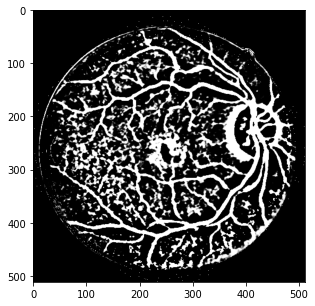

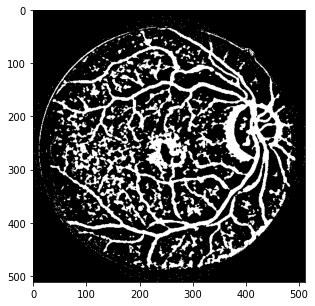

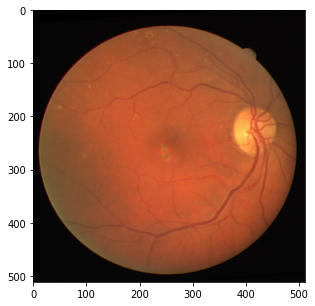

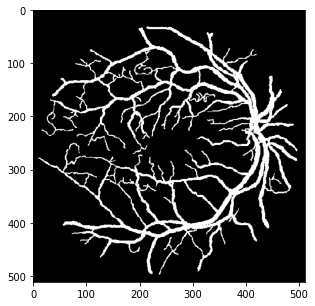

In [26]:
n = 11
show(decs[n, 1, :, :])
show(1.0*(decs[n, 0, :, :] < decs[n, 1, :, :]))
show(train_images[n, :, :, :])
show(train_masks[n, :, :])

In [27]:
# Jaccard and Dice
#
pr = 1.0 * (decs[:, 0, :, :] < decs[:, 1, :, :]).flatten()
tg = train_masks.flatten()
jaccard = sklearn.metrics.jaccard_score(tg, pr)
dice = 2 * jaccard / (jaccard + 1)
print(jaccard, dice)

0.3882995583428195 0.559388722713884


In [101]:
decs.min(), decs.max()

(-0.19619815051555634, 0.5872899293899536)

In [139]:
x = torch.arange(1 * 3 * 4 * 4).reshape(1, 3, 4, 4).float()
y = torch.arange(1 * 3 * 4 * 4).reshape(1, 3, 4, 4).float()
print(x / (y + EPSILON))

tensor([[[[0.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]]]])


In [230]:
conv = torch.nn.Conv2d(in_channels=3, out_channels=3,
                       kernel_size=5, stride=1,
                       padding='same', bias=False)
conv.weight.requires_grad_(False)
conv.weight = torch.nn.Parameter(
    torch.zeros_like(conv.weight), requires_grad=False)
for c in range(3):
    conv.weight[c, c, :, :] = 1.0

In [232]:
conv.weight.shape

torch.Size([3, 3, 5, 5])

In [19]:
# LocallyNonlinear(
#   (convs): ModuleList(
#     (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
#     (1): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
#     (2): Conv2d(3, 3, kernel_size=(13, 13), stride=(1, 1), padding=same, bias=False)
#     (3): Conv2d(3, 3, kernel_size=(21, 21), stride=(1, 1), padding=same, bias=False)
#     (4): Conv2d(3, 3, kernel_size=(31, 31), stride=(1, 1), padding=same, bias=False)
#     (5): Conv2d(3, 3, kernel_size=(43, 43), stride=(1, 1), padding=same, bias=False)
#     (6): Conv2d(3, 3, kernel_size=(57, 57), stride=(1, 1), padding=same, bias=False)
#     (7): Conv2d(3, 3, kernel_size=(73, 73), stride=(1, 1), padding=same, bias=False)
#     (8): Conv2d(3, 3, kernel_size=(91, 91), stride=(1, 1), padding=same, bias=False)
#   )
#   (aggregate): Conv2d(1596, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
# )
# Device:  cuda:0
# Weight:  tensor([0.1232, 0.8768])
# Ep: 0, Secs: 33, loss: 0.6254
# Ep: 10, Secs: 332, loss: 0.5677
# Ep: 20, Secs: 332, loss: 0.4973
# Ep: 30, Secs: 332, loss: 0.4893
# Ep: 40, Secs: 332, loss: 0.4865
# Ep: 50, Secs: 332, loss: 0.4842
# Ep: 60, Secs: 332, loss: 0.4819
# Ep: 70, Secs: 332, loss: 0.4803
# Ep: 80, Secs: 332, loss: 0.4783
# Ep: 90, Secs: 332, loss: 0.4775
# Ep: 99, Secs: 299, loss: 0.4729
# Finished in 3343 seconds.
# 0.3882995583428195 0.559388722713884